In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.0-preview2/spark-3.0.0-preview2-bin-hadoop2.7.tgz
!tar -xvf spark-3.0.0-preview2-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-preview2-bin-hadoop2.7"
import findspark
findspark.init()

tar: spark-3.0.0-preview2-bin-hadoop2.7.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


Exception: ignored

In [ ]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

In [ ]:

spark = SparkSession.builder.getOrCreate()

In [ ]:

msnpc = spark.read.csv("MsNPC.csv", header = True,inferSchema=True)
msplayer = spark.read.csv("MsPlayer.csv", header = True,inferSchema=True)
msweapon = spark.read.csv("MsWeapon.csv", header = True,inferSchema=True)
msweapontype = spark.read.csv("MsWeaponType.csv", header = True,inferSchema=True)
transactiondetail = spark.read.csv("TransactionDetail.csv", header = True,inferSchema=True)
transactionheader = spark.read.csv("TransactionHeader.csv", header = True,inferSchema=True)

msnpc.createOrReplaceTempView("MsNPC")
msplayer.createOrReplaceTempView("MsPlayer")
msweapon.createOrReplaceTempView("MsWeapon")
msweapontype.createOrReplaceTempView("MsWeaponType")
transactionheader.createOrReplaceTempView("TransactionHeader")
transactiondetail.createOrReplaceTempView("TransactionDetail")

In [ ]:
res1 = spark.sql("SELECT WeaponTypeName , sum(quantity*WeaponPrice) as Total FROM MsWeaponType a JOIN MsWeapon b ON a.WeaponTypeId = b.WeaponTypeId JOIN TransactionDetail c ON b.WeaponId = c.WeaponId JOIN TransactionHeader d ON c.TransactionId = d.TransactionId WHERE YEAR(TransactionDate)=2019 GROUP BY WeaponTypeName")

res1 =res1.toPandas()

In [ ]:
res1

,WeaponTypeName,Total
0,Sword,24300000
1,Axe,36184000
2,Bow,26484000
3,Flail,25748000
4,Scythe,22833000


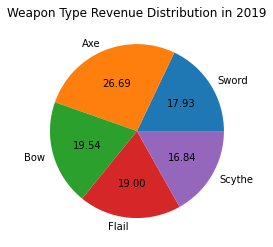

In [ ]:
plt.title("Weapon Type Revenue Distribution in 2019")
plt.pie(res1["Total"],labels=res1["WeaponTypeName"], autopct= "%.2f" )
plt.show()

In [ ]:
res2 = spark.sql ("SELECT MONTH(TransactionDate) as Month,COUNT(distinct PlayerId) as Total FROM TransactionHeader a JOIN TransactionDetail b ON a.transactionId = b.transactionId JOIN MsWeapon c on b.WeaponId = c.WeaponId JOIN MsWeaponType d ON c.WeaponTypeId = d.WeaponTypeId Where d.WeaponTypeName LIKE 'Axe' and YEAR (TransactionDate)=2019 GROUP BY MONTH(TransactionDate) ORDER BY  MONTH(TransactionDate) asc ")

res2 =res2.toPandas()

In [ ]:
res2

,Month,Total
0,1,8
1,2,7
2,3,5
3,4,6
4,5,4
5,6,5
6,7,4
7,8,3
8,9,1
9,10,6


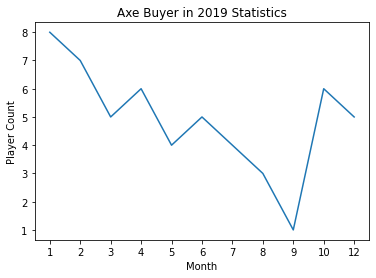

In [ ]:
plt.plot(res2["Total"])
plt.xticks(range(len(res2["Month"])),res2["Month"])
plt.title("Axe Buyer in 2019 Statistics")
plt.xlabel("Month")
plt.ylabel("Player Count")
plt.show()

In [ ]:
res3 = spark.sql ("SELECT x.Monthly, COUNT(x.Monthly) as Frequency FROM (SELECT MONTH(TransactionDate),CASE WHEN SUM(Quantity*WeaponPrice) > 2000000 THEN 'Extinction' WHEN SUM(Quantity*WeaponPrice) BETWEEN 1500000 AND 1999999 THEN 'Nightfall' WHEN SUM(Quantity*WeaponPrice) BETWEEN 1000000 AND 1499999 THEN 'Strom Breaker' END AS Monthly FROM MsPlayer a JOIN TransactionHeader b ON a.PlayerId = b.PlayerId JOIN TransactionDetail c ON b.transactionId = c.transactionId JOIN MsWeapon d on c.WeaponId = d.WeaponId WHERE PlayerGender LIKE 'Female' AND YEAR (TransactionDate) = 2019 Group BY PlayerName,MONTH(TransactionDate) Order By SUM(Quantity*WeaponPrice) desc) as x GROUP BY x.Monthly ORDER BY  Case When x.Monthly ='Strom Breaker' THEN 1 WHEN x.Monthly ='Extinction' THEN 2 WHEN x.Monthly ='Nightfall' THEN 3 END")
res3 = res3.na.drop()
res3 = res3.toPandas()
res3

,Monthly,Frequency
0,Strom Breaker,17
1,Extinction,7
2,Nightfall,9


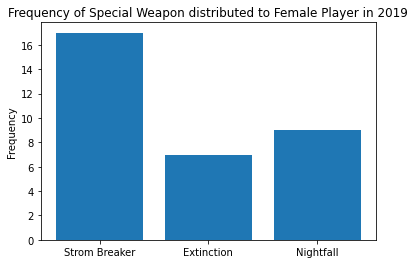

In [ ]:
plt.title("Frequency of Special Weapon distributed to Female Player in 2019")
plt.ylabel("Frequency")
plt.bar(res3["Monthly"], res3["Frequency"])
plt.show()

In [ ]:
res4= spark.sql("SELECT x.Month,Count(x.PlayerId) as Count FROM(SELECT Month(TransactionDate) as Month,PlayerId,count(distinct weapontypeid) FROM transactionheader aa join transactiondetail bb on aa.transactionid=bb.transactionid JOIN msweapon cc on bb.weaponid = cc.weaponid group by month(transactiondate),playerid HAVING count(distinct weapontypeid) > 2 ) as x GROUP BY x.Month ORDER BY x.Month ")
res4 = res4.toPandas()
res4

,Month,Count
0,1,6
1,2,5
2,3,4
3,4,3
4,5,3
5,6,3
6,7,5
7,8,2
8,9,1
9,10,5


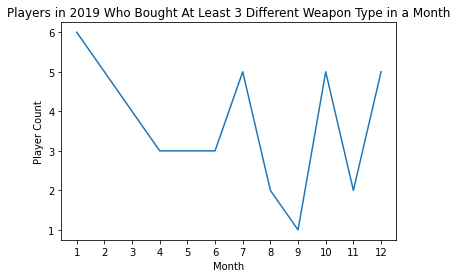

In [ ]:
plt.plot(res4["Count"])
plt.xticks(range(len(res4["Month"])),res4["Month"])
plt.title("Players in 2019 Who Bought At Least 3 Different Weapon Type in a Month")
plt.xlabel("Month")
plt.ylabel("Player Count")
plt.show()

In [ ]:
res5 = spark.sql ("SELECT x.Popularity, COUNT(x.Popularity) as Frequency FROM (SELECT a.NPCId,CASE WHEN SUM(Quantity*WeaponPrice) >= 15000000 THEN 'Very Popular' WHEN SUM(Quantity*WeaponPrice) BETWEEN 7500000 AND 14999999 THEN 'Popular' WHEN SUM(Quantity*WeaponPrice) BETWEEN 2500000 AND 7499999 THEN 'Quite Popular' WHEN SUM(Quantity*WeaponPrice) < 2500000 THEN 'Not Popular' END AS Popularity FROM MsNPC a JOIN TransactionHeader b ON a.NPCId = b.NPCId JOIN MsPlayer pp ON b.PlayerId = pp.PlayerId JOIN TransactionDetail c ON b.transactionId = c.transactionId JOIN MsWeapon d on c.WeaponId = d.WeaponId Group BY a.NPCId HAVING COUNT(distinct pp.PlayerId)>4 ) as x GROUP BY x.Popularity ORDER BY  Case When x.Popularity ='Quite Popular' THEN 1 WHEN x.Popularity ='Popular' THEN 2 WHEN x.Popularity ='Very Popular' THEN 3 END ")
res5 = res5.toPandas()
res5

,Popularity,Frequency
0,Quite Popular,2
1,Popular,8
2,Very Popular,2


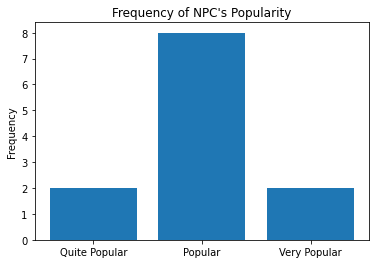

In [ ]:
plt.title("Frequency of NPC's Popularity")
plt.ylabel("Frequency")
plt.bar(res5["Popularity"], res5["Frequency"])
plt.show()